# Классификация комментариев на позитивные и негативные

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем  распоряжении набор данных с разметкой о токсичности правок.

Криетрий успешности: значение метрики качества *F1* модели должно быть не меньше 0.75. 


**Описание данных**

Данные находятся в файле `---.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импорты

In [1]:
# импорты из стандартной библиотеки
import warnings

# импорты сторонних библиотек
import numpy as np
import pandas as pd
import lightgbm
import re
import nltk
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
import spacy

# импорты модулей

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from nltk.corpus import stopwords as nltk_stopwords
stopwords = set(nltk_stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    KFold,
    TimeSeriesSplit,
    train_test_split
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from spacy.lang.en import English
from sklearn.pipeline import Pipeline


# настройки
warnings.filterwarnings("ignore")

# константы
RANDOM_STATE = 42

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
df = pd.read_csv('-----.csv', index_col=0)
df.sample(5)

,text,toxic
53810,Thanks for messing with my scratchpad. Real ki...,0
28165,"""\nWell, I wanted to get 26328 Litomyšl a DYK,...",0
158141,. the other use has also said it was vandalism...,0
130158,July 2015 \n\nHello. I would like to let you k...,0
16386,New logo 2010-08-12 \n\n (Italian)\n (Italia...,0


Тексты в файле на английском языке.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
df.describe()

,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<AxesSubplot:>

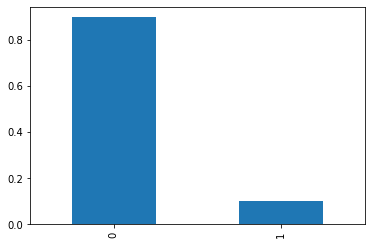

In [5]:
df['toxic'].value_counts(normalize=True).plot(kind='bar')

Признак "toxic" установлен для 10% текстов.
Пропусков нет.

### Очистка

Необходимо подготовить данные для анализа:  перевести все в нижний регистр, оставить только латиницу, и удалить stop_words.

In [6]:
def clear_text(text):    
    stop_words = set(nltk_stopwords.words('english'))
    text = text.lower()
    word_list = re.sub(r"[^a-z ]", ' ', text).split()
    word_notstop_list = [w for w in word_list if not w in stop_words]
    return ' '.join(word_notstop_list)

In [7]:
df['clean_text'] = df['text'].apply(clear_text)
df.sample(5)

,text,toxic,clean_text
36913,Since when do definitions or encyclopedia entr...,0,since definitions encyclopedia entries speak o...
108944,PUZZLE CURIOUS GOGGLE FOR EARTH SOLUTION CLIMA...,0,puzzle curious goggle earth solution climate c...
101450,"""\n\nArbitration enforcement action appeal by ...",0,arbitration enforcement action appeal wookiein...
136229,Thanks to everyone for their patience with thi...,0,thanks everyone patience things deal last mont...
50728,"March 2015 (UTC)\n\nWhat is this, fighting a f...",0,march utc fighting fish discussion already rfc...


In [8]:
df.duplicated().sum()

0

Дубликатов нет.

### Лемматизация WordNetLemmatizer

In [9]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [10]:
def postag_lemm_text(text):    
    lemmatizer = WordNetLemmatizer()
    word_list = text.split()
    lemmatized_text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list])
    return lemmatized_text

In [11]:
df['lemm_text'] = df['clean_text'].apply(postag_lemm_text)
df.sample(5)

,text,toxic,clean_text,lemm_text
125123,"Replying to your message, as your e-mail was n...",0,replying message e mail available good afterno...,reply message e mail available good afternoon ...
49565,Hello and welcome to Wikipedia! Hope you like ...,0,hello welcome wikipedia hope like stick around...,hello welcome wikipedia hope like stick around...
156136,They have bad credit rating also,0,bad credit rating also,bad credit rating also
36596,Mere Propoganda \n\nThe claims are merely poli...,0,mere propoganda claims merely political proble...,mere propoganda claim merely political problem...
26838,the escrow and carry considerable liability to...,0,escrow carry considerable liability attorney s...,escrow carry considerable liability attorney s...


In [12]:
def lemm_text_2(text):   
    lemmatizer = spacy.load('en_core_web_sm') 
    word_list = lemmatizer(text)
    lemmatized_text = ' '.join([w.lemma_ for w in word_list])
    return lemmatized_text
lemm_text_2('A letter has been written, asking him to be released')

'a letter have be write , ask he to be release'

### Вывод


1. Загружены и изучены исходные данные.
2. В данных нет пропусков и дубликатов.
3. Присутствует дисбаланс классов у целевого признака (только 10% текстов имеют признак токсичный).
4. Данные лемматизированы.

## Обучение

### Разделение на выборки

In [13]:
features = df.drop('toxic',axis=1)
target = df['toxic']

In [14]:
features_train, features_test, target_train, target_test = train_test_split(
    features, 
    target, 
    test_size=0.2, stratify=target, shuffle=True, random_state=RANDOM_STATE)

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(127433, 3)
(31859, 3)
(127433,)
(31859,)


### Изменение баланса классов

В разделе "Подготовка" мы выяснили, что только 10% данных имеют признак *toxic*. Проверим на обучающей выборке.

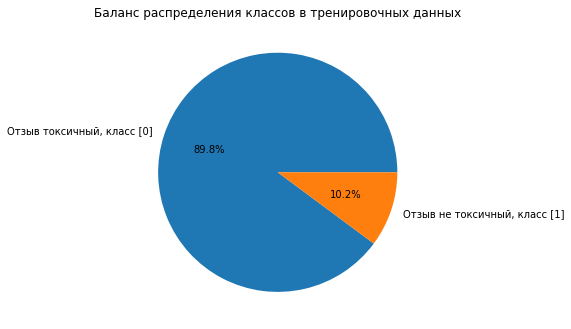

In [15]:
target_train.value_counts(normalize=True).plot(kind='pie',figsize=[5.5,5.5], legend=False, autopct='%1.1f%%',labels=['Отзыв токсичный, класс [0]','Отзыв не токсичный, класс [1]'])
plt.title('Баланс распределения классов в тренировочных данных')
plt.ylabel('')
plt.show()

 В данных преобладают "нетоксичные" комментарии. 

### LogisticRegression

In [22]:
kfold = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

In [23]:
%%time

lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)),
    ('clf', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'))])

lr_params = {'clf__C': [9, 100],
             'clf__max_iter': range (14, 16),
             'tfidf__ngram_range':  [(1,1),  (1,3)]}

lr_grid = GridSearchCV(estimator=lr_pipe, param_grid=lr_params, cv=kfold, scoring='f1', n_jobs=-1, refit=False)
lr_grid.fit(features_train['lemm_text'], target_train)
lr_best_paramms = lr_grid.best_params_

print(lr_best_paramms)
print(lr_grid.best_score_)

{'clf__C': 9, 'clf__max_iter': 15, 'tfidf__ngram_range': (1, 3)}
0.7639567159827978
CPU times: user 9min 14s, sys: 3min 22s, total: 12min 37s
Wall time: 12min 38s


###  LGBMClassifier

In [26]:
%%time

lgb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)),
    ('clf', LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])

params = {
  'clf__n_estimators': [50, 200],
  'clf__learning_rate': [0.25, 0.15],
  'clf__max_depth': [ 10, -1],
  'tfidf__ngram_range':  [(1,1), (1,3)]}

lgb_grid = GridSearchCV(estimator=lgb_pipe, param_grid=params, cv=kfold, scoring='f1', n_jobs=-1, refit=False)
lgb_grid.fit(features_train['lemm_text'], target_train)
lgb_best_params = lgb_grid.best_params_

print(lgb_best_params)
print(lgb_grid.best_score_)

{'clf__learning_rate': 0.25, 'clf__max_depth': 10, 'clf__n_estimators': 50, 'tfidf__ngram_range': (1, 1)}
0.7295819203064543
CPU times: user 27min 14s, sys: 10.5 s, total: 27min 24s
Wall time: 27min 31s


In [27]:
result = pd.DataFrame(
     [lr_grid.best_score_,  lgb_grid.best_score_] , 
    index=['LogisticRegression', 'LGBMClassifier'], 
    columns=['f1']
)
result

,f1
LogisticRegression,0.763957
LGBMClassifier,0.729582


Лучшее значение метрики `f1` у модели Логистической регрессии.

### Тестирование модели

Проверим лучшую модель на тестовой выборке.

In [28]:
vectorize = TfidfVectorizer(ngram_range=(1,3),
               min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)

In [31]:
features_train = vectorize.fit_transform(features_train['lemm_text'])
features_test = vectorize.transform(features_test['lemm_text'])

In [32]:
lr_m = LogisticRegression(C=9, max_iter=15, class_weight='balanced', random_state=RANDOM_STATE)
lr_m.fit(features_train, target_train)

target_predict_lr = lr_m.predict(features_test)
f1_score_lr = f1_score(target_test, target_predict_lr)
f1_score_lr

0.7610350076103501

## Выводы

Нашей целью было найти и обучить модель для магазина "Викишоп", которая способна классифицировать комментарии на позитивные и негативные для того, чтобы в дальнейшем токсичные отзывы отправлялись на модерацию. При этом достигуть результата предсказания наилучшей модели по метрике *F1*  не меньше  0.75. 

В нашем распоряжении был набор данных с разметкой о токсичности комментариев, но для правильной работы предсказательных алгоритмов моделей нам пришлось очистить комментарии от лишних символов.

Для определения наилучшей модели мы остановили наш выбор на двух моделях *LogisticRegression*, *LGBMClassifier*. По итогам сравнеиня лучшей оказалась модель **LogisticRegression** с гиперпараметрами(-  C': 9, 'max_iter': 15),  значение *f1* метрики 0.761.

Таким мы можем  рекомендовать к использованию данную модель для классифицирования комментариев на позитивные и негативные в магазине.